In [ ]:
import numpy as np
import matplotlib.pyplot as plt


## Question2

In [ ]:
def phi(v ,A, b):
  """the barrier function"""
  if ((b-A.dot(v)).min() > 0):
    return - np.sum(np.log(b - A.dot(v)))
  else: return np.inf


In [ ]:
def centering_step(Q, p, A, b, t, v0, eps, Niter=10000):
  v_seq = [v0]
  for i in range(Niter):
    v = v_seq[-1]
    grad_phi = A.T.dot(1 / (b - A @ v)) #gradient of the log barrier
    hess_phi = A.T @ np.diag(1 / (b - A @ v)**2) @ A #the hessian of the log barrier
    
    grad_v = t * (2 * Q @ v + p) + grad_phi 
    H = 2 * t * Q + hess_phi 
    L = np.linalg.cholesky(H)
    L_inv = np.linalg.inv(L)
    dum = L_inv @ grad_v #to avoid doing the same operation multiple times
    decrement = -L_inv.T @ dum
    lambda_squared = dum.dot(dum)

    if lambda_squared / 2 < eps: #stopping condition
      return v_seq
  #backtracking line search
    alpha = 1 
    back_test = lambda alpha: t * (alpha**2 * (decrement.T @ Q @ decrement)  + 0.75 * alpha * grad_v.dot(decrement))  + (phi(v + alpha * decrement, A, b) - phi(v, A, b) - 0.25 * alpha * grad_phi.dot(decrement))
    while ( back_test(alpha) >=0):
      alpha /= 2

    v_seq.append(v + alpha * decrement)


In [ ]:
def barr_method(Q, p, A, b, v0, eps, t0=1, mu=2, Niter=10000, m=None):
  v_seq = [v0]
  nbr_iterations = [] #sequence of the number of inner iterations for each outer iteration
  t = t0
  if m==None: m = b.shape[0]
  for i in range(Niter):
    v = centering_step(Q, p, A, b, t, v0, eps)
    v0 = v[-1]
    v_seq.append(v0)
    nbr_iterations.append(len(v))
    if m/t < eps:
      return v_seq, nbr_iterations
    t *= mu
    


In [ ]:
def LASSO_dual(X, y, lam=10, t0=1, v0=0, eps=10e-4, mu=50, Niter=10000):
  n , d = X.shape
  return barr_method(np.eye(n) / 2, y, np.vstack((X.T, -X.T)), lam * np.ones(2*d),v0, eps, t0, mu, Niter)

## Question3

In [ ]:
#test on random data:
eps = 10e-8
n = 51
d = 100
X = np.random.rand(n, d)
y = np.random.rand(n)

Q = 1/2 * np.eye(n)
A = np.vstack((X.T, -X.T))
b = 10 *np.ones(2*d)
p = y
v0 = np.zeros(n)

f = lambda v: v.dot(v) / 2 + y.dot(v)

In [ ]:
#trying out different values for mu
mu_range = [ 2, 15, 50, 100, 250, 500, 600, 700, 1000]
v_seq_mu = []
value_seq_mu = []
ind = 0
n_mu = len(mu_range)
f_star = np.inf
f_star_ind = 0
nbr_iterations_mu = []
for i in range(n_mu):
  v_seq, nbr_iterations = barr_method(Q, p, A, b, v0, eps, mu=mu_range[i])
  value_seq = np.array(list(map(f, v_seq)))

  if value_seq[-1] < f_star:
    f_star = value_seq[-1]
    f_star_ind = i
  value_seq_mu.append(value_seq)
  v_seq_mu.append(v_seq)
  nbr_iterations_mu.append(nbr_iterations)



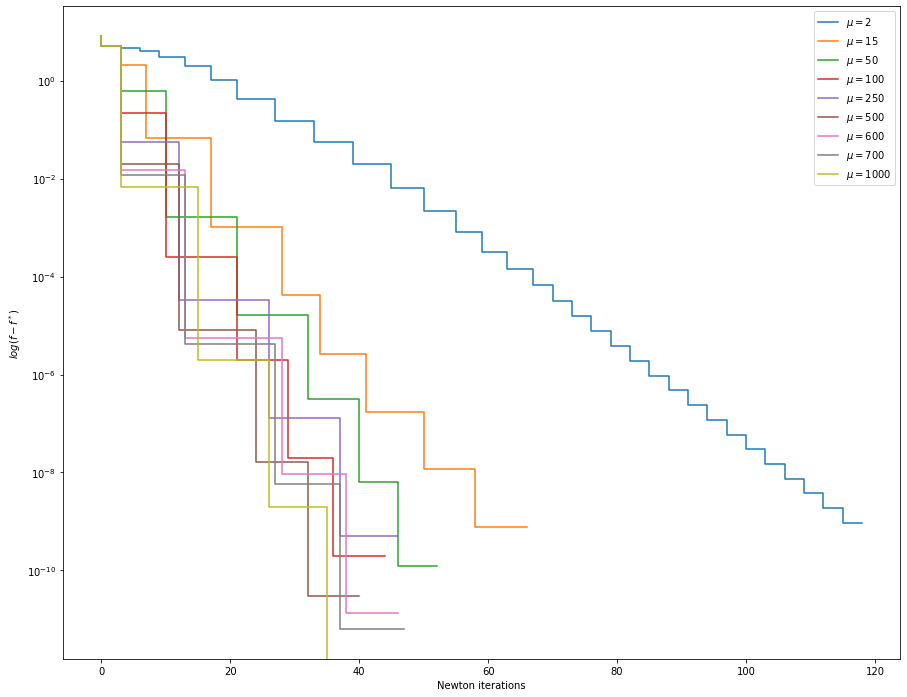

In [ ]:
#making the corresponding plots
plt.figure(figsize=(15,12))
for i in range(n_mu):
  xaxis = np.concatenate((np.zeros(1), np.cumsum(nbr_iterations_mu[i])))#xaxis as the accumulation of newtons iterations accross barrier method runs
  yaxis = value_seq_mu[i] - f_star
  plt.yscale("log")
  mu = str(mu_range[i])
  plt.step(xaxis, yaxis, label="$\mu=$"+mu)
  plt.xlabel("Newton iterations")
  plt.ylabel("$log(f-f^*)$")
  plt.legend()

plt.show()

It's hard to choose a specific better value for mu as most perform relativly the same. On the other hand, some values are fairly easy to rule out (manly the very small ones like 2 for example). In the runs I made 700 and 500 seem to perform consistently better than the others (odd?) in this specific case.

## Visualizing the convergence of $v^*(t)$ for n=2



In [ ]:
#visualizing for n = 2
eps = 10e-10
n = 2
d = 30
X = np.random.rand(n, d)
y = np.random.rand(n)

Q = 1/2 * np.eye(n)
A = np.vstack((X.T, -X.T))
b = 0.1 *np.ones(2*d) #lambda = 0.1 for visulization convenience
p = y
v0 = np.zeros(n)
v_seq, nbr_iterations = barr_method(Q, p, A, b, v0, eps, m=1)
f = lambda v: v.dot(v) / 2 + y.dot(v)

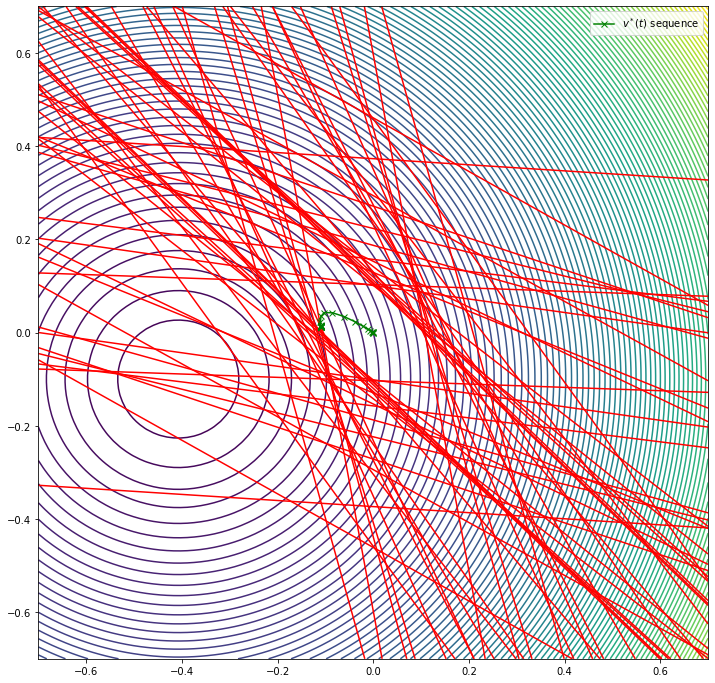

In [ ]:
#1- ploting  level sets of our objective:
uax, vax = np.linspace(-0.7, 0.7, 100), np.linspace(-0.7, 0.7, 100)
U, V = np.meshgrid(uax, vax)
F = np.zeros((100, 100))
for i in range(100):
  for j in range(100):
    v = np.array([U[i, j], V[i ,j]])
    F[i,j] = f(v)

plt.figure(figsize=(12,12))
#2-ploting the barrier method sequence 
plt.contour(U, V, F, levels=100)
xx, yy = np.array(v_seq).T
plt.plot(xx, yy, color='green', label="$v^*(t)$ sequence", marker='x')

# ploting the barrier
for i in range( 2 * d):
  bar = np.zeros((100, 100))
  for k in range(100):
    for l in range(100):
      v = np.array([U[k, l], V[k ,l]])
      bar[k,l] = A[i].dot(v) 
  plt.contour(U, V, bar, levels = [b[i]], cmap='autumn')
plt.legend()
plt.show()

## Visualizing a sequence of $w^*(t)$ for d=2

In [ ]:
#visualizing for d = 2
eps = 10e-10
n = 1
d = 2
X = np.random.rand(n, d)
y = np.random.rand(n)

Q = 1/2 * np.eye(n)
A = np.vstack((X.T, -X.T))
lam = 0.1
b = lam *np.ones(2*d) #lambda = 0.1 for visulization convenience
p = y
v0 = np.zeros(n)
v_seq, nbr_iterations = barr_method(Q, p, A, b, v0, eps, m=1, mu=20)

g = lambda w: np.linalg.norm(X@w - y) + lam * np.linalg.norm(w, ord=1)


In [ ]:
#recuperating w* from v* (w* is might not (and is not when d > n) be unique we pick one by solving for w in Xw-y = v* using the least squares method)
w_seq = []
for v in v_seq:
  w_seq.append(np.linalg.lstsq(X, y+v)[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


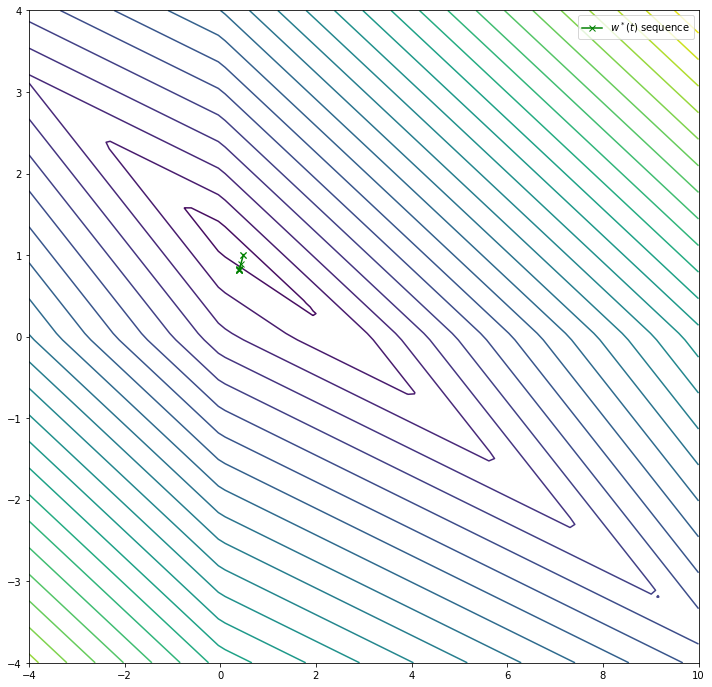

In [ ]:
#1- ploting  level sets of our objective:
uax, vax = np.linspace(-4, 10, 100), np.linspace(-4, 4, 100)
U, V = np.meshgrid(uax, vax)
G = np.zeros((100, 100))
for i in range(100):
  for j in range(100):
    w = np.array([U[i, j], V[i ,j]])
    G[i,j] = g(w)

plt.figure(figsize=(12,12))
#2-ploting the sequence
plt.contour(U, V, G, levels=30)

xx, yy = np.array(w_seq).T
plt.plot(xx, yy, color='green', label="$w^*(t)$ sequence", marker='x')


plt.legend()
plt.show()